# 時系列データをトレンド・季節/周期性・残差に分解する

In [1]:
# Google　Colaboratory で実行する場合はインストールする
if "google.colab" in str(get_ipython()):
    !pip install japanize_matplotlib
    !pip install seaborn
    !pip install statsmodels

In [2]:
import japanize_matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
import os

if os.path.exists("../../stylesheet/k_dm.mplstyle"):
    plt.style.use("../../stylesheet/k_dm.mplstyle")

## サンプルデータを作成
周期的な数値を複数組合せ、さらに区分的にトレンドが変化しています。また `np.random.rand()` でノイズも乗せています。

In [4]:
date_list = pd.date_range("2021-01-01", periods=365, freq="D")
value_list = [
    10
    + i % 14
    + np.log(1 + i % 28 + np.random.rand())
    + np.sqrt(1 + i % 7 + np.random.rand()) * 2
    + (((i - 100) / 10)) * (i > 100)
    - ((i - 200) / 7) * (i > 200)
    + np.random.rand()
    for i, di in enumerate(date_list)
]

df = pd.DataFrame(
    {
        "日付": date_list,
        "観測値": value_list,
    }
)

df.head(10)

,日付,観測値
0,2021-01-01,13.347196
1,2021-01-02,15.832995
2,2021-01-03,17.708271
3,2021-01-04,19.101793
4,2021-01-05,21.004753
5,2021-01-06,22.148626
6,2021-01-07,24.010228
7,2021-01-08,22.032234
8,2021-01-09,23.827791
9,2021-01-10,25.502515


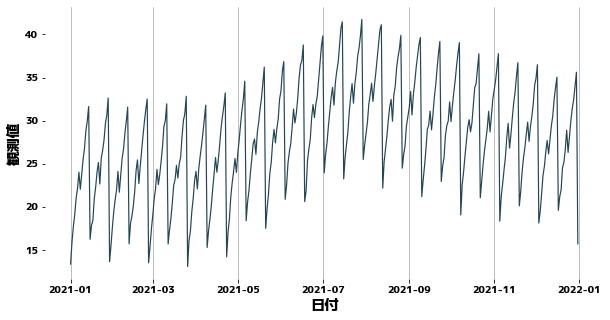

In [5]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=df["日付"], y=df["観測値"])
plt.grid(axis="x")
plt.show()

# トレンド・季節/周期性・残差に分解する
[statsmodels.tsa.seasonal.seasonal_decompose](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)を用いて時系列データを

- トレンド(.trend)
- 季節/周期性(.seasonal)
- 残差(.resid)

に分解してみます。（以下のコード中のdrは[DecomposeResult](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.DecomposeResult.html#statsmodels.tsa.seasonal.DecomposeResult)を指しています。）

In [6]:
dr = seasonal_decompose(df["観測値"], model="additive", period=28)

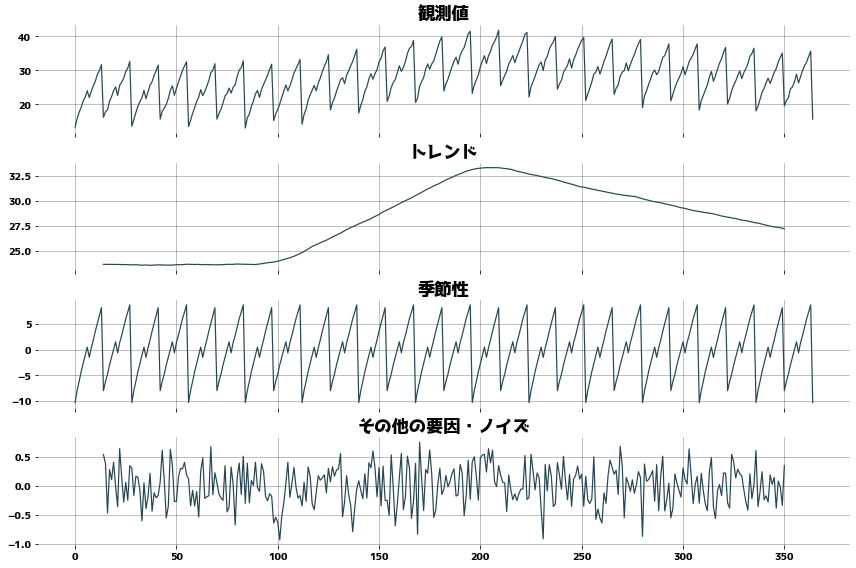

In [7]:
_, axes = plt.subplots(figsize=(12, 8), ncols=1, nrows=4, sharex=True)

axes[0].set_title("観測値")
axes[0].plot(dr.observed)
axes[0].grid()

axes[1].set_title("トレンド")
axes[1].plot(dr.trend)
axes[1].grid()

axes[2].set_title("季節性")
axes[2].plot(dr.seasonal)
axes[2].grid()

axes[3].set_title("その他の要因・ノイズ")
axes[3].plot(dr.resid)
axes[3].grid()

plt.tight_layout()
plt.show()

# トレンドを捉えることができているか確認する
もしもトレンドが正しく抽出できている場合は、トレンドに周期的な要素が含まれていないはずであり、PACF（偏自己相関）が０に近くなるはずです。

- [statsmodels.tsa.stattools.acf](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html)
- [statsmodels.tsa.stattools.pacf](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.pacf.html)

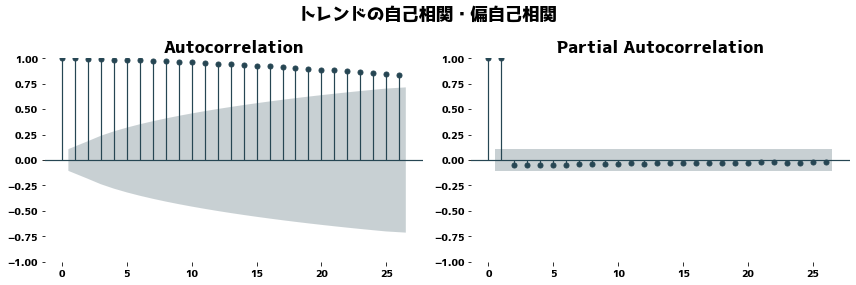

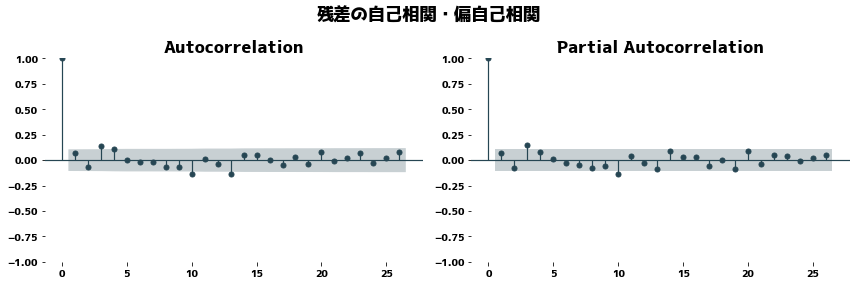

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.suptitle("トレンドの自己相関・偏自己相関")
plot_acf(dr.trend.dropna(), ax=axes[0])
plot_pacf(dr.trend.dropna(), method="ywm", ax=axes[1])
plt.tight_layout()
plt.show()

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.suptitle("残差の自己相関・偏自己相関")
plot_acf(dr.resid.dropna(), ax=axes[0])
plot_pacf(dr.resid.dropna(), method="ywm", ax=axes[1])
plt.tight_layout()
plt.show()

## 残差に対するかばん検定

In [9]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(dr.resid.dropna(), lags=int(np.log(df.shape[0])))

,lb_stat,lb_pvalue
1,1.803938,0.179237
2,3.531262,0.171079
3,9.992312,0.018632
4,13.897574,0.007629
5,13.907515,0.016208


## トレンドを近似する

区分的な線形関数で近似してみます。
コードは[ruoyu0088/segments_fit.ipynb](https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a)のものを使用しています。

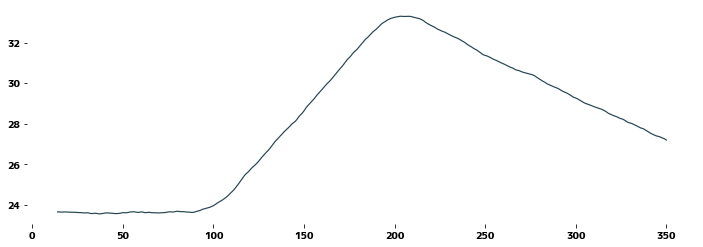

In [10]:
plt.figure(figsize=(12, 4))
trend_data = dr.trend.dropna()
plt.plot(trend_data)
plt.show()

In [11]:
from scipy import optimize


def segments_fit(X, Y, count):
    """
    original: https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a by ruoyu0088
    """
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array(
        [Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init]
    )

    def func(p):
        seg = p[: count - 1]
        py = p[count - 1 :]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2) ** 2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method="Nelder-Mead")
    return func(r.x)

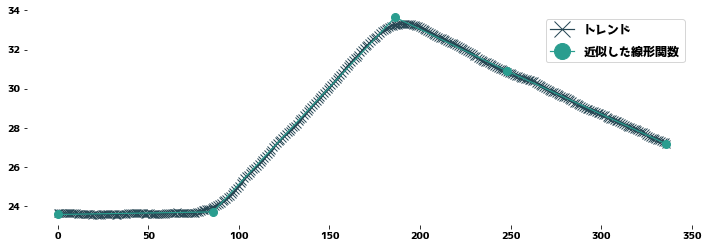

In [12]:
x = np.arange(0, len(trend_data))
y = trend_data

plt.figure(figsize=(12, 4))
px, py = segments_fit(x, y, 4)
plt.plot(x, y, "-x", label="トレンド")
plt.plot(px, py, "-o", label="近似した線形関数")
plt.legend()